# Homework Solution - Week 4
## Different evaluation metrics for classification model

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get the data
PATH = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv"

df = pd.read_csv(PATH)

In [3]:
# view first five rows
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


### Data Preparation

In [4]:
# Map values 'yes' to 1 and 'no' to 0 in response variable `card`
df['card'] = df.card.map(lambda x : 1 if x=='yes' else 0)

In [5]:
# split the data into training, validation and test datasets using `train_test_split` method
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

Question 1
--

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [6]:
# Create a list for numeric and categorical columns
numerical_cols = ['reports','age','income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

In [7]:
from sklearn.metrics import roc_auc_score

scores = {}
for col in numerical_cols:
    score = roc_auc_score(df_train['card'], df_train[col])
    if score < 0.5:
        score = roc_auc_score(df_train['card'], -df_train[col])
    scores[col] = score

scores

{'reports': 0.7166629860689376,
 'age': 0.5240020979407055,
 'income': 0.5908049467233478,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873,
 'dependents': 0.5327757227773791,
 'months': 0.5294217780967629,
 'majorcards': 0.5343859842838476,
 'active': 0.6043173411362006}

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

**Answer - `share`**

# Training model

In [8]:
# feature selection
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [9]:
from sklearn.feature_extraction import DictVectorizer

def OH_encoder(data):

    dv = DictVectorizer(sparse=False)
    dicts = data[features].to_dict(orient='records')
    data_transform = dv.fit_transform(dicts)

    return data_transform

In [10]:
from sklearn.linear_model import LogisticRegression

# data preparation
X_train = OH_encoder(df_train)
y_train = df_train.card.values

# model training
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# model evaluation 
X_val = OH_encoder(df_val)
y_val = df_val.card.values

y_preds = model.predict_proba(X_val)[:, 1]

Question 2
----
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995


**Answer: 0.995**

In [11]:
auc = roc_auc_score(y_val, (y_preds>=0.5).astype(int))
print("The auc score of this model on validation dataset is %.3f" %(auc))

The auc score of this model on validation dataset is 0.974


Question 3
---
Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [12]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.arange(0.0, 1.0, 0.01)
precisions, recalls = [], []

for t in thresholds:
    y_predicts = (y_preds >= t).astype(int)

    predicted_positive = (y_predicts == 1)
    predicted_negative = (y_predicts == 0)

    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()

    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    precisions.append(p)
    recalls.append(r)

At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

**Answer: 0.3**

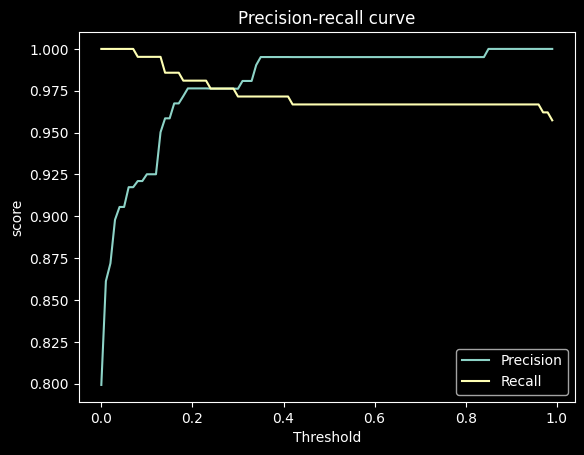

In [13]:
# plot
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

plt.xlabel("Threshold")
plt.ylabel("score")
plt.title("Precision-recall curve")

plt.legend()
plt.show()

Question 4
---
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

**Answer - 0.4**

In [14]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_score = []

for t in thresholds:
    y_predicts = (y_preds >= t).astype(int)

    predicted_positive = (y_predicts == 1)
    predicted_negative = (y_predicts == 0)

    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()

    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    score = (2 * precision * recall) / (precision + recall)
    f1_score.append(score)

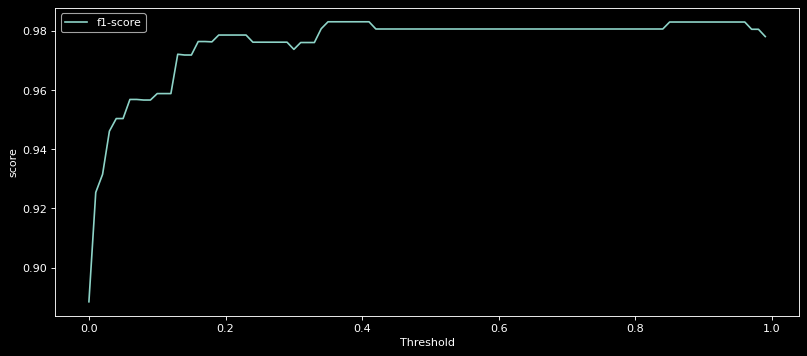

In [15]:
# plot
plt.figure(figsize=(12, 5), dpi=80)
plt.plot(thresholds, f1_score, label='f1-score')

plt.xlabel("Threshold")
plt.ylabel("score")

plt.legend()
plt.show()

Question 5
---

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

**Answer - 0.014**

In [16]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # data preparation
    X_train = OH_encoder(df_train)
    y_train = df_train.card.values 

    X_val = OH_encoder(df_val)
    y_val = df_val.card.values 

    # train a model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # predict the output
    y_preds = model.predict(X_val)

    # model evaluation
    auc = roc_auc_score(y_val, y_preds) 
    scores.append(auc)

print("Mean: %f, std: %f" %(np.mean(scores), np.std(scores)))


Mean: 0.983349, std: 0.011596


Question 6
---
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

**Answer - 0.01**

In [17]:
c = {}
for C in [0.01, 0.1, 1, 10]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # data preparation
        X_train = OH_encoder(df_train)
        y_train = df_train.card.values 

        X_val = OH_encoder(df_val)
        y_val = df_val.card.values 

        # train a model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # predict the output
        y_preds = model.predict(X_val)

        # model evaluation
        auc = roc_auc_score(y_val, y_preds) 
        scores.append(auc)

    c[C] = round(np.mean(scores)), round(np.std(scores), 3)

In [20]:
score_df = pd.DataFrame(data=c.values(), index=c.keys(), columns=['mean', 'std'])
score_df.style.highlight_min(subset=['std'], color='orange', axis=0)

,mean,std
0.010000,1,0.007000
0.100000,1,0.010000
1.000000,1,0.012000
10.000000,1,0.014000
